In [99]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod

# Base Classes

<div style="color: green; font-weight:
bold">The solution is equivalent to the sample solution in performance and functionality. However the method find_thresholds is implemented differently. The sample solution takes n_mins into account, whereas this solution doesn't. This yields different results for the thresholds.</div>

In [100]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
        

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        ... # your code here
        node.left = left
        node.right = right
        node.split_index = j_min
        node.threshold = t_min
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        ... # your code here
        active_indices = np.random.choice(D, D_try, replace=False)
        return active_indices

        
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        ... # your code here
        unique_values = np.unique(node.features[:, j])
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
        return thresholds

        
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        ... # your code here
        
        # feature matrix and response vector of the parent node
        features = node.features
        responses = node.responses

        # split features and responses based on the selected feature and threshold
        left_mask = features[:, j] <= t
        right_mask = ~left_mask

        left.features = features[left_mask]
        left.responses = responses[left_mask]

        right.features = features[right_mask]
        right.responses = responses[right_mask]

        return left, right

        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")



# Regression Tree

<div style="color: green; font-weight:
bold">The solution is completely equivalent to the sample solution.</div>

In [101]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        ... # your code here
        
        left_mask = node.features[:, j] <= t
        right_mask = ~left_mask

        left_responses = node.responses[left_mask]
        right_responses = node.responses[right_mask]

        sse_left = np.sum((left_responses - np.mean(left_responses)) ** 2)
        sse_right = np.sum((right_responses - np.mean(right_responses)) ** 2)
        return sse_left + sse_right
        
    def make_leaf_node(self, node):
        node.prediction = np.mean(node.responses)
        

# Classification Tree

<div style="color: green; font-weight:
bold">The solution uses the gini impurity instead of the cross entropy loss, which is also viable. Performance wise it looks good by using the ~ operator instead of calculating the masks again. The make_leaf node function on the other hand is calculated by using the most likely prediction with argmax. Instead, the sample solution is using the mean of all leaf nodes for a given class. </div>

In [102]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        ... # your code here 
        left_mask = node.features[:, j] <= t
        right_mask = ~left_mask
        left_responses = node.responses[left_mask]
        right_responses = node.responses[right_mask]
        gini_left = self.calculate_gini_impurity(left_responses)
        gini_right = self.calculate_gini_impurity(right_responses)
        n_left = len(left_responses)
        n_right = len(right_responses)
        total_samples = n_left + n_right
        gini_split = (n_left / total_samples) * gini_left + (n_right / total_samples) * gini_right
        return gini_split
        
    def make_leaf_node(self, node):
        unique_classes, class_counts = np.unique(node.responses, return_counts=True)
        majority_class = unique_classes[np.argmax(class_counts)]
        node.prediction = majority_class
        
    def calculate_gini_impurity(self, responses):
        class_counts = np.bincount(responses)
        class_probs = class_counts / len(responses)
        gini = 1.0 - np.sum(class_probs ** 2)
        return gini
    
        

# Evaluation of Regression and Classification Tree

<div style="color: green; font-weight:
bold">The implementation for the cross validation is correct and equivalent to the sample solution, with the exception, that no mean error was given and the test error was evaluated only after the training, not for each fold. This comment applies to both, the regression tree and the classification tree evaluation. Performance wise there should not be any siginificant differences.</div>

In [103]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 0)|(digits.target == 1)|(digits.target == 2)|(digits.target == 3)|(digits.target == 4)|(digits.target == 5)|(digits.target == 6)|(digits.target == 7)|(digits.target == 8) | (digits.target == 9) 
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [104]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
... # your code here

from sklearn.model_selection import KFold
n_min = 10
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

regression_tree_acc = []
for train_idx, test_idx in kf.split(features):
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = responses[train_idx], responses[test_idx]
    regression_tree = RegressionTree(n_min=n_min)
    regression_tree.train(X_train, y_train)
    predictions = [regression_tree.predict(x) for x in X_test]
    accuracy = np.mean(predictions == y_test)
    regression_tree_acc.append(accuracy)

print("Accuracy for RegressionTree:", regression_tree_rmse)
print("The accuracy of the regression tree shows a inclining pattern after 5-fold cross-validation")


Accuracy for RegressionTree: [0.9041095890410958, 0.9041095890410958, 0.9315068493150684, 0.9444444444444444, 0.9722222222222222]
The accuracy of the regression tree shows a inclining pattern after 5-fold cross-validation


In [105]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results
... # your code here
n_min = 10
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

classification_tree_accuracy = []
for train_idx, test_idx in kf.split(features):
    X_train, X_test = features[train_idx], features[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]

    classification_tree = ClassificationTree(classes=np.unique(labels), n_min=n_min)
    classification_tree.train(X_train, y_train)

    predictions = [classification_tree.predict(x) for x in X_test]
    accuracy = np.mean(predictions == y_test)
    classification_tree_accuracy.append(accuracy)

print("Accuracy for ClassificationTree:", classification_tree_accuracy)
print("The accuracy of the classification tree also shows a inclining pattern after 5-fold cross-validation, but slightly less accurate than the regression tree")


Accuracy for ClassificationTree: [0.8583333333333333, 0.8, 0.7688022284122563, 0.8189415041782729, 0.7883008356545961]
The accuracy of the classification tree also shows a inclining pattern after 5-fold cross-validation, but slightly less accurate than the regression tree


# Regression and Classification Forest

<div style="color: green; font-weight:
bold">The bootstrap function is equivalent in every aspect to the sample solution.</div>

In [106]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    ... # your code here
    N = features.shape[0]
    indices = np.random.choice(N, size=N, replace=True)
    bootstrap_features = features[indices]
    bootstrap_responses = responses[indices]
    return bootstrap_features, bootstrap_responses

<div style="color: green; font-weight:
bold">The regression forest is equivalent in every aspect to the sample solution.</div>

In [107]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        predictions = [tree.predict(x) for tree in self.trees]
        return np.mean(predictions)

<div style="color: green; font-weight:
bold">The classification forest is implemented equivalently with only minor implementation differences in the predict function, which neither affect performance nor functionality.</div>

In [108]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        ... # your code here
        predictions = [tree.predict(x) for tree in self.trees]
        unique_classes, counts = np.unique(predictions, return_counts=True)
        most_common_class = unique_classes[np.argmax(counts)]
        return most_common_class

# Evaluation of Regression and Decision Forest

<div style="color: green; font-weight:
bold">The cross validation is again implemented correctly and equivallently to the sample solution. The results however are not as good as in the sample solution which might be due to a suboptimal random sample in the bootstrap sample function. This applies also for the classification forest.</div>

In [109]:
from sklearn.model_selection import KFold

# Create the RegressionForest and ClassificationForest
regression_forest = RegressionForest(n_trees=10)

# Perform 5-fold cross-validation for RegressionForest
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_responses, test_responses = responses[train_index], responses[test_index]

    # Train the RegressionForest
    regression_forest.train(train_features, train_responses)

    # Evaluate the RegressionForest
    predictions = [regression_forest.predict(x) for x in test_features]
    accuracy = np.mean(predictions == test_responses)
    print("RegressionForest accuracy:", accuracy)

RegressionForest accuracy: 0.6583333333333333
RegressionForest accuracy: 0.7194444444444444
RegressionForest accuracy: 0.6824512534818942
RegressionForest accuracy: 0.649025069637883
RegressionForest accuracy: 0.6657381615598886


In [110]:
# Create the ClassificationForest
classification_forest = ClassificationForest(n_trees=10, classes=np.unique(labels))
# Perform 5-fold cross-validation for ClassificationForest
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

    # Train the ClassificationForest
    classification_forest.train(train_features, train_labels)

    # Evaluate the ClassificationForest
    predictions = [classification_forest.predict(x) for x in test_features]
    accuracy = np.mean(predictions == test_labels)
    print("ClassificationForest accuracy:", accuracy)

ClassificationForest accuracy: 0.9
ClassificationForest accuracy: 0.8638888888888889
ClassificationForest accuracy: 0.9415041782729805
ClassificationForest accuracy: 0.9498607242339833
ClassificationForest accuracy: 0.8885793871866295


# Multi-class Classification Forest

<div style="color: green; font-weight:
bold">The multi-class classification forest is implemented correctly and efficiently. The confusion matrix is averaged over all folds instead of used directly like in the sample solution. Furthermore the confusion matrix is not normalized. There is a parameter for this in sklearn's confusion matrix function. This means it is harder to see the classification accuracy on each class.</div>

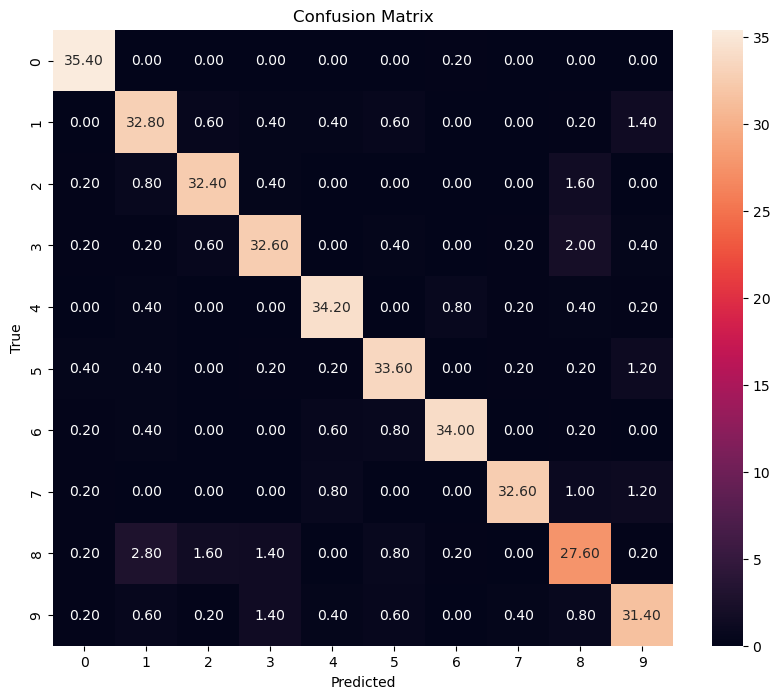

each cell represents the count of times a certain digit was predicted when a different digit was actually supposed to be predicted. When the values are higher on the diagonal, from the top left to the bottom right, it indicates accurate predictions where the predicted digit matches the true digit. Cells outside the diagonal indicate cases of misclassifications. Here we can see that there are only few instances where the prediction is wrong, rest all matches the true values


In [112]:
# Train ClassificationForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
classification_forest = ClassificationForest(n_trees=10, classes=np.unique(digits.target))
confusion_mat = np.zeros((10, 10))
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    classification_forest.train(train_features, train_labels)
    predictions = [classification_forest.predict(x) for x in test_features]
    confusion_mat_fold = confusion_matrix(test_labels, predictions, labels=np.unique(digits.target))
    confusion_mat += confusion_mat_fold
confusion_mat_avg = confusion_mat / 5
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_avg, annot=True, fmt=".2f", xticklabels=np.unique(digits.target), yticklabels=np.unique(digits.target))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print("each cell represents the count of times a certain digit was predicted when a different digit was actually supposed to be predicted. When the values are higher on the diagonal, from the top left to the bottom right, it indicates accurate predictions where the predicted digit matches the true digit. Cells outside the diagonal indicate cases of misclassifications. Here we can see that there are only few instances where the prediction is wrong, rest all matches the true values")

# One-against-the-rest classification with RegressionForest

<div style="color: green; font-weight:
bold">The confusion matrix is again not normalized and does not contain the unknown class from the prediction. This can be solved by changing the shape of confusion_mat to (11, 11) and adding the unknown class to the class array when computing the confusion matrix for a given fold. Furthermore, the dataset is not balanced causing it to overfit towards rejecting a given digit. One can balance the dataset after relabeling by using a cutoff determined by the minority class.</div>

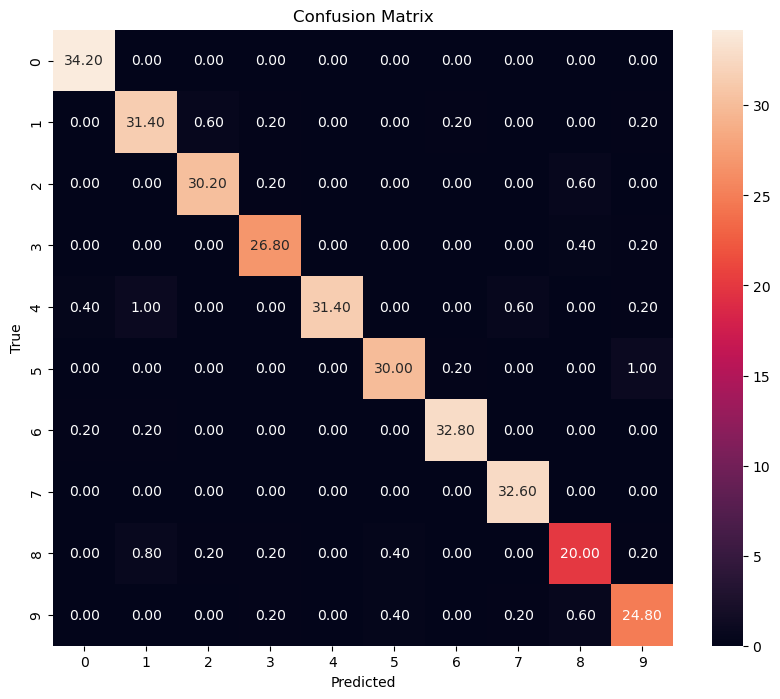

Each cell in the matrix represents the number of instances where a specific digit was predicted when the actual digit was another specific digit. When the values are higher along the diagonal, running from the top left to the bottom right, it signifies accurate predictions where the predicted digit matches the true digit. On the other hand, cells outside the diagonal represent instances of misclassifications.


In [113]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Assign test instances to the digit with the highest score,
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.

from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = np.zeros((10, 10))
kf = KFold(n_splits=5)
for train_index, test_index in kf.split(features):
    train_features, test_features = features[train_index], features[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]
    regression_forests = []
    for i in range(10):
        modified_train_labels = np.where(train_labels == i, 1, -1)
        regression_forest = RegressionForest(n_trees=10)
        regression_forest.train(train_features, modified_train_labels)
        regression_forests.append(regression_forest)

    
    predictions = []
    for test_instance in test_features:
        scores = [forest.predict(test_instance) for forest in regression_forests]
        max_score = max(scores)
        if max_score >= 0:
            predicted_digit = scores.index(max_score)
        else:
            predicted_digit = -1
        predictions.append(predicted_digit)

    confusion_mat_fold = confusion_matrix(test_labels, predictions, labels=np.unique(digits.target))
    confusion_mat += confusion_mat_fold
confusion_mat_avg = confusion_mat / 5

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_avg,annot=True, fmt=".2f", xticklabels=np.unique(digits.target), yticklabels=np.unique(digits.target))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print("Each cell in the matrix represents the number of instances where a specific digit was predicted when the actual digit was another specific digit. When the values are higher along the diagonal, running from the top left to the bottom right, it signifies accurate predictions where the predicted digit matches the true digit. On the other hand, cells outside the diagonal represent instances of misclassifications.")
